# Calculate Nino 3.4 index to check if eruptions line up with El Nino events
This script opens up all the CMIP6 historical model run files with data on precipitation pr and surface temperature tas and loops over the files. It calculates the Nino3.4 index for the data to test which years have an El Nino event and if they occur after volcanic eruptions. 


In [2]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load

In [3]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [4]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [5]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5

v20200302


In [6]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


## Read in model data

In [7]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/tas/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/tas/gr1.5/v20190630/*.nc
Path for MCM-UA-1-0 does not exist
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/tas/gr1.5/v20190919/*.nc
Model MPI-ESM1-2-HR has different time so is now removed
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/tas/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr1.5/v20180803/*.nc
CAS-ESM2-0 /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/tas/gr1.5/v20200302/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/tas/gr1.5/v20190927/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/Amon/tas/gr1.5/v20190818/*.nc
BCC-ESM1 

In [8]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/pr/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/pr/gr1.5/v20190630/*.nc
Path for MCM-UA-1-0 does not exist
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/pr/gr1.5/v20190919/*.nc
MPI-ESM1-2-HR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/pr/gr1.5/v20190710/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/pr/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/pr/gr1.5/v20180803/*.nc
CAS-ESM2-0 /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5/v20200302/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/pr/gr1.5/v20190927/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p

In [9]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [10]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.04 GB,1.38 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,36929 Tasks,7260 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.07 GB,2.76 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,45181 Tasks,7260 Chunks
Type,float64,numpy.ndarray


In [11]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [12]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [13]:
# area weighting 
models_w = models*np.cos(models_tas.lat*(np.pi/180))

In [14]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

## do i need to use a landmask here??

In [37]:
models_Glob = models_w.where(landmask.data==1, drop=True)
# with dask.config.set(**{'array.slicing.split_large_chunks': True}):
#     models_w[indexer]
# return self.models_w[key]

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

In [15]:
# models_SH = models_w.sel(lat=slice(-90,0)) 
# models_NH = models_w.sel(lat=slice(0,90)) 
# models_Aus = models_w.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
# models_EA = models_w.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

## Nino 3.4

In [115]:
region = models_w.sel(lat=slice(-5,5), lon=slice(190,240))

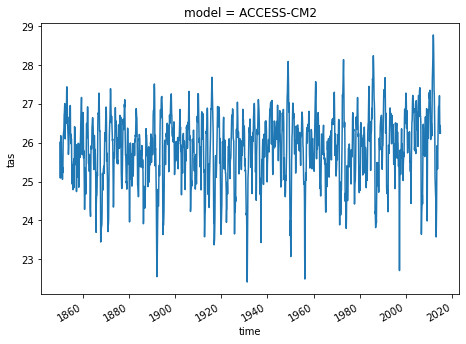

In [147]:
(region.sel(model='ACCESS-CM2').tas.mean(dim=['lat','lon'])-273).plot(size=5)

## check i did anomalies correctly

In [130]:
anom = func.monthly_anom_xr(region, '1850-01', '1881-01')

In [143]:
anom_mean = anom.mean(dim=['lat','lon'])

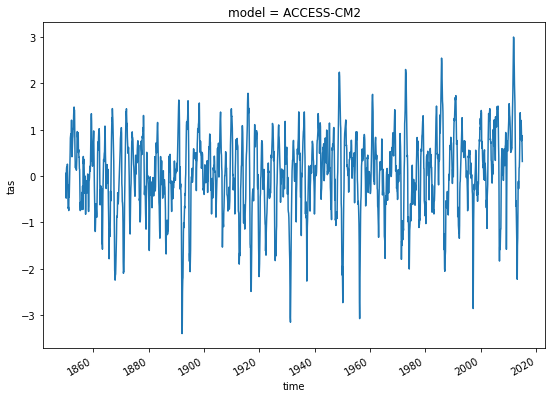

In [145]:
anom_mean.sel(model='ACCESS-CM2').tas.plot(size=5)

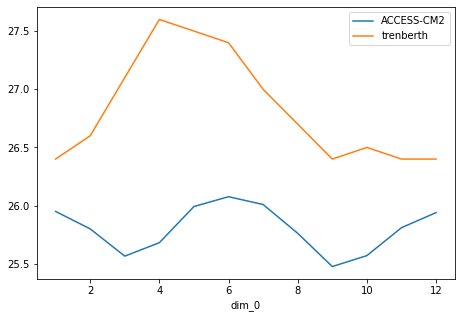

In [118]:
(clim.sel(model='ACCESS-CM2').tas - 273).plot(size=5, label = 'ACCESS-CM2') # makes a temporary datset 
mean_sst_trenberth = xr.DataArray([26.4, 26.6, 27.1, 27.6, 27.5, 27.4, 27.0, 26.7, 26.4, 26.5, 26.4, 26.4], coords=[np.arange(12)+1])
mean_sst_trenberth.plot(label='trenberth')
plt.legend()

In [136]:
nino34_rolling = anom_mean.rolling(time=5).mean(dim=['time'])
nino34_rolling

ValueError: For window size 5, every chunk should be larger than 2, but the smallest chunk size is 1. Rechunk your array
with a larger chunk size or a chunk size that
more evenly divides the shape of your array.

In [137]:
std = region.sel(time = slice('1850-01', '1881-01')).mean(dim=['lat', 'lon']).std(dim = ['time'])
std

<xarray.Dataset>
Dimensions:  (model: 43)
Coordinates:
  * model    (model) <U17 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
Data variables:
    tas      (model) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    pr       (model) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [138]:
nino34_final = anom_mean/std

In [139]:
dataset = nino34_final.sel(model='ACCESS-CM2').tas
dataset

<xarray.DataArray 'tas' (time: 1980)>
dask.array<getitem, shape=(1980,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2014-12-31
    model    <U17 'ACCESS-CM2'
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [140]:
dataset.time

<xarray.DataArray 'time' (time: 1980)>
array(['1850-01-31T00:00:00.000000000', '1850-02-28T00:00:00.000000000',
       '1850-03-31T00:00:00.000000000', ..., '2014-10-31T00:00:00.000000000',
       '2014-11-30T00:00:00.000000000', '2014-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2014-12-31
    model    <U17 'ACCESS-CM2'
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [141]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

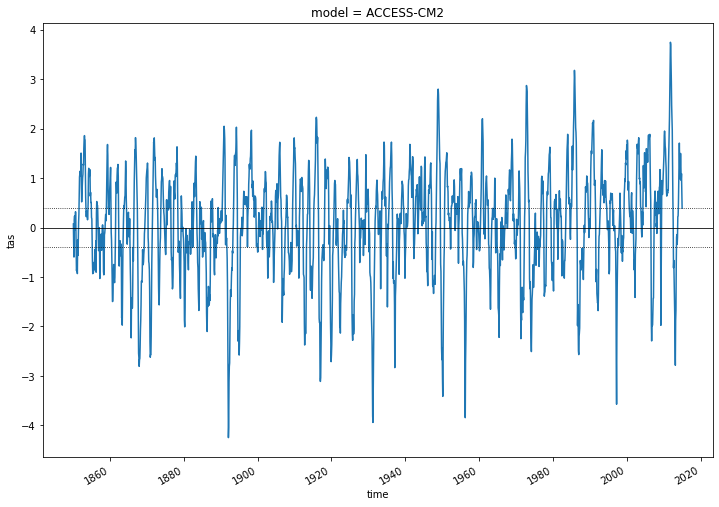

In [142]:
dataset.plot(size=8)
plt.axhline(0, color='k', lw=0.8)
plt.axhline(0.4, color='k', lw=0.8, linestyle = ':')
plt.axhline(-0.4, color='k', lw=0.8, linestyle = ':')


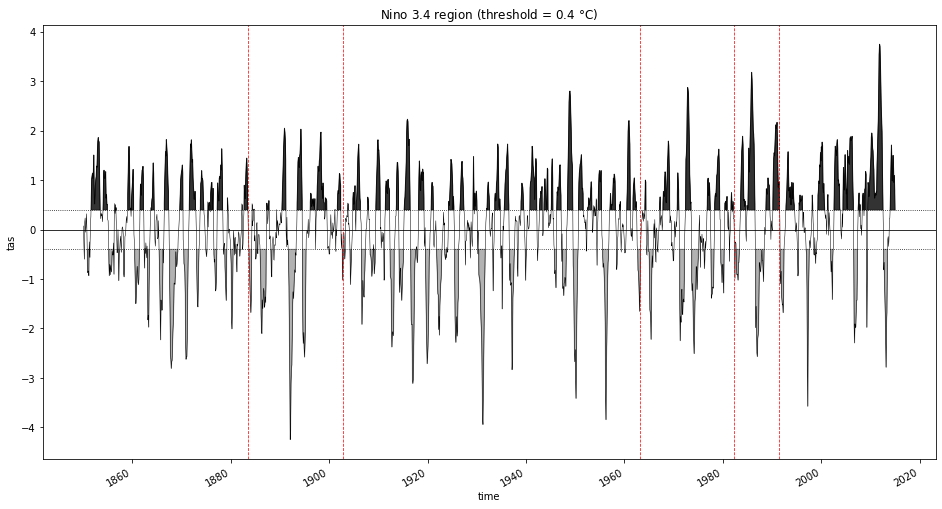

In [155]:
# recreate figure from trenberth paper as an extension
fig = plt.figure(figsize=(16,8))
# alpha is the opacity 
plt.fill_between(dataset.time.values, dataset.where(dataset>=0.4).values, 0.4, color='k', alpha=0.8)
plt.fill_between(dataset.time.values, dataset.where(dataset<=-0.4).values, -0.4, color='k', alpha=0.3)
dataset.plot(color='k', lw=0.5)
plt.axhline(0, color='k', lw=0.8)
plt.axhline(0.4, color='k', lw=0.8, linestyle = ':')
plt.axhline(-0.4, color='k', lw=0.8, linestyle = ':')
plt.title('Nino 3.4 region (threshold = 0.4 $\degree$C)')

for date in e_date:
    plt.axvline(x=date, color = 'red', linestyle = '--', alpha = 0.9, linewidth='0.8')

In [ ]:
# percentage of el nino events
"percentage of el nino events = {:0.1f}%".format(100 * (nino34_final.where(nino34_final>=0.4).count() / nino34_final.count()).values)

## Figures

In [16]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [18]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()